## Import libraries

In [1]:
# system and performance
import gc
import time
import os
import pickle


# date management
import datetime
import calendar


# data management
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)

from itertools import product

# visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


# machine learning
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

In [2]:
def create_directory(path):
    if not os.path.isdir(path):
        os.mkdir(path)
        print('directory '+path+' created succesfully !')
    else:
        print('directory '+path+' already exists')

In [3]:
def downcast_dtypes(df):
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols = [c for c in df if df[c].dtype in ["int64", "int32"]]
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols] = df[int_cols].astype(np.int16)
    return df

In [4]:
# path to data
RAW_DATA_FOLDER = '../data/raw/'
DATA_FOLDER = '../data/'

##### Define core variable space and macro to reset variable space

In [5]:
loaded=%who_ls
loaded.append('loaded')

In [6]:
all_vars=%who_ls
all_vars.append('all_vars')
for var in list(set(all_vars)-set(loaded)):
    exec('del '+var)
del var

In [7]:
%macro reset_variable_space 6
loaded.append('reset_variable_space')

Macro `reset_variable_space` created. To execute, type its name (without quotes).
=== Macro contents: ===
all_vars=get_ipython().run_line_magic('who_ls', '')
all_vars.append('all_vars')
for var in list(set(all_vars)-set(loaded)):
    exec('del '+var)
del var
 

## -------------------------------------------------------------

# 6 - TRAINING FOR PREDICTION

## Functions for training and validation

In [8]:
# SPLIT TRAIN-TEST SET
def datasplit_train_test(train_df,month_id_first=0):
    if month_id_first==0:
        month_id_first=train_df['month_id'].min()
        
    # TRAINING SET
    X_train=train_df.loc[(train_df['month_id']>=month_id_first)&(train_df['month_id']<34),:].astype(np.float32)
    Y_train=X_train['item_quantity'].astype(np.float32)
    X_train.drop(['month_id','item_quantity'],axis=1,inplace=True)

    print(X_train.shape, Y_train.shape)

    # TEST SET
    X_test=train_df.loc[train_df['month_id']==34,:].astype(np.float32)
    X_test.drop(['month_id','item_quantity'],axis=1,inplace=True)

    print(X_test.shape)

    return (X_train,Y_train,X_test)





# SPLIT TRAINING SET MONTH BY MONTH
def datasplit_evalset(train_df,month_id_first=0):
    if month_id_first==0:
        month_id_first=train_df['month_id'].min()
        
    eval_set=[]
    for mid in train_df['month_id'].unique():
        if (mid>=month_id_first)&(mid<34):
            X_val=train_df.loc[(train_df['month_id']==mid),:].astype(np.float32)
            Y_val=X_val['item_quantity'].astype(np.float32)
            X_val.drop(['month_id','item_quantity'],axis=1,inplace=True)
            eval_set.append((X_val,Y_val))
        
    return eval_set

In [9]:
# ANALYSIS OF TARGET VALUE AND NAIVE PREDICTIONS
def target_analysis_test(train_df,month_id_first=0):

    # split dataset
    (X_train,Y_train,_) = datasplit_train_test(train_df,month_id_first)
    evalset = datasplit_evalset(train_df,month_id_first)

    # BASE SCORE
    base_score=Y_train.mean()
    base_score_evalset=[Y.mean() for (_,Y) in evalset]

    # BENCHMARK (guess with 0 everywhere)
    Y_guess_train=0*Y_train
    rmse_guess_train=np.sqrt(mean_squared_error(Y_train, Y_guess_train))

    Y_base_train=0*Y_train+base_score
    rmse_base_train=np.sqrt(mean_squared_error(Y_train, Y_base_train))

    print('#### TRAINING SET ###')
    print('mean target value: '+str(base_score))
    print('RMSE (guess,base): '+str(rmse_guess_train)+' , '+str(rmse_base_train))

    rmse_guess_evalset=[]
    rmse_base_evalset=[]
    for (_,Y) in evalset:
        Y_guess=0*Y
        rmse_guess_evalset.append(np.sqrt(mean_squared_error(Y, Y_guess)))

        Y_base=0*Y+Y.mean()
        rmse_base_evalset.append(np.sqrt(mean_squared_error(Y, Y_base)))

    print('#### EVAL SET ###')
    print('mean target value: '+str([round(b*1e4)/1e4 for b in base_score_evalset]))
    print('RMSE (guess): '+str([round(b*1e2)/1e2 for b in rmse_guess_evalset]))
    print('RMSE (base): '+str([round(b*1e2)/1e2 for b in rmse_base_evalset]))

    fig,axes=plt.subplots(1,2,figsize=(15,5))
    axes[0].plot(train_df.loc[(train_df['month_id']>=month_id_first)&(train_df['month_id']<34),'month_id'].unique(),base_score_evalset,'-o')
    axes[0].set_xlabel('month_id')
    axes[0].set_ylabel('mean of target value')
    axes[0].grid(True)
    axes[0].set_ylim(bottom=0)

    axes[1].plot(train_df.loc[(train_df['month_id']>=month_id_first)&(train_df['month_id']<34),'month_id'].unique(),rmse_guess_evalset,'-o')
    axes[1].plot(train_df.loc[(train_df['month_id']>=month_id_first)&(train_df['month_id']<34),'month_id'].unique(),rmse_base_evalset,'-o')
    axes[1].set_xlabel('month_id')
    axes[1].set_ylabel('rmse')
    axes[1].legend(['guess = 0','mean value'])
    axes[1].grid(True)
    axes[1].set_ylim(bottom=0)
    
    return rmse_guess_train, rmse_base_train, rmse_guess_evalset, rmse_base_evalset

In [10]:
# PERFORMANCES ON TRAINING SET
def performance_analysis_test(xgbreg,rmse_guess_train,rmse_base_train,rmse_guess_evalset,rmse_base_evalset):

    rmse_evalset_last=[]
    rmse_evalset_min=[]
    for evset in xgbreg.evals_result().values():
        rmse_evalset_last.append(evset['rmse'][-1])
        rmse_evalset_min.append(min(evset['rmse']))

    # display
    print('#### TRAINING SET ###')
    print('RMSE (last, min, base, guess): '+str(rmse_evalset_last[0]) +' , '+str(rmse_evalset_min[0])+' , '+str(rmse_base_train)+' , '+str(rmse_guess_train))
    print()
    print('#### EVAL SET ###')
    print('RMSE (last): '+str([round(b*1e4)/1e4 for b in rmse_evalset_last[1:]]))
    print('RMSE (min): '+str([round(b*1e4)/1e4 for b in rmse_evalset_min[1:]]))
    print('RMSE (base): '+str([round(b*1e4)/1e4 for b in rmse_base_evalset]))
    print('RMSE (guess): '+str([round(b*1e4)/1e4 for b in rmse_guess_evalset]))


    fig,axes=plt.subplots(1,2,figsize=(15,5))
    for i in range(1,len(xgbreg.evals_result())):
        evset=xgbreg.evals_result()['validation_'+str(i)]['rmse']
        axes[0].plot(evset,'-o')
    axes[0].legend(range(0,len(eval_set)))
    axes[0].plot(xgbreg.evals_result()['validation_0']['rmse'],'k',linewidth=5)


    axes[1].plot(rmse_evalset_last[1:],'-o')
    axes[1].plot(0*np.array(rmse_evalset_last[1:])+rmse_evalset_last[0],'k')
    axes[1].plot(rmse_evalset_min[1:],'-o')
    axes[1].plot(0*np.array(rmse_evalset_min[1:])+rmse_evalset_last[0],'r')
    axes[1].plot(rmse_guess_evalset,'k-s')
    axes[1].set_xlabel('month_id')
    axes[1].set_ylabel('rmse (last,min)')
    axes[1].grid(True)
    axes[1].set_ylim(bottom=0)

In [11]:
# FEATURE IMPORTANCE
def plot_feature_importance(xgbreg,X_train):
    # gain     := improvement in accuracy resulting from a split according to this feature (measured by a reduction of the optimization metric)
    # weight   := number of times a feature is used to split the data across all trees
    # coverage := number of observations that are classified according to this feature in the tree

    n_features=len(X_train.columns)
    
    fi_types=[ 'total_gain' , 'gain', 'weight', 'cover' , 'total_cover']
    xgb_fi=pd.DataFrame(index=X_train.columns)
    for typ in fi_types:
        xgb_fi[typ]=pd.Series(data=xgbreg.get_booster().get_score(importance_type=typ),index=X_train.columns)

    xgb_fi.fillna(0,inplace=True)
    xgb_fi=xgb_fi.sort_values(by='gain',ascending=True)

    fig,ax=plt.subplots(1,5,figsize=(18,np.floor(n_features/2.5)))
    for i,typ in enumerate(fi_types[0:5]):
        if i==0:
            ax[i].barh(y=xgb_fi.index,width=xgb_fi[typ].values)
        else:
            ax[i].barh(y=xgb_fi.index,width=xgb_fi[typ].values,tick_label=[None])
        ax[i].grid(True)
        ax[i].set_title(typ)

In [12]:
loaded=%who_ls
loaded.append('loaded')

## ----------------------------------------------

In [13]:
# create directories
create_directory(os.path.join(DATA_FOLDER, 'predictions'))
create_directory(os.path.join(DATA_FOLDER, 'predictions/models/'))

directory ../data/predictions already exists
directory ../data/predictions/models/ already exists


## SENIORITY 2

### Import and process training set

In [14]:
dataset_name='train_2_pred'
month_id_first=18

train_X=pd.read_pickle(os.path.join(DATA_FOLDER,'training/'+dataset_name+'.pkl'))

print(train_X.info(null_counts=True,verbose=True))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3510374 entries, 4463079 to 10840136
Data columns (total 145 columns):
month_id                                                                               3510374 non-null int8
item_category_id                                                                       3510374 non-null int8
item_quantity                                                                          3510374 non-null float32
shop_months_since_opening                                                              3510374 non-null int8
item_freq_in_seniority                                                                 3510374 non-null float32
item_category_freq                                                                     3510374 non-null float32
item_supercategory_freq                                                                3510374 non-null float32
item_category_console_freq                                                             3510374 non-null 

(2353906, 143) (2353906,)
(111511, 143)
#### TRAINING SET ###
mean target value: 0.4324004352092743
RMSE (guess,base): 1.4344214 , 1.3676968236541185
#### EVAL SET ###
mean target value: [0.4062, 0.4639, 0.3864, 0.4126, 0.4346, 0.7168, 0.5459, 0.4255, 0.409, 0.3427, 0.3575, 0.3778, 0.3875, 0.425, 0.3729, 0.3761]
RMSE (guess): [1.32, 1.52, 1.29, 1.45, 1.44, 2.18, 1.72, 1.36, 1.31, 1.23, 1.2, 1.28, 1.26, 1.31, 1.25, 1.26]
RMSE (base): [1.26, 1.45, 1.23, 1.39, 1.37, 2.06, 1.64, 1.29, 1.24, 1.18, 1.14, 1.22, 1.2, 1.24, 1.2, 1.2]


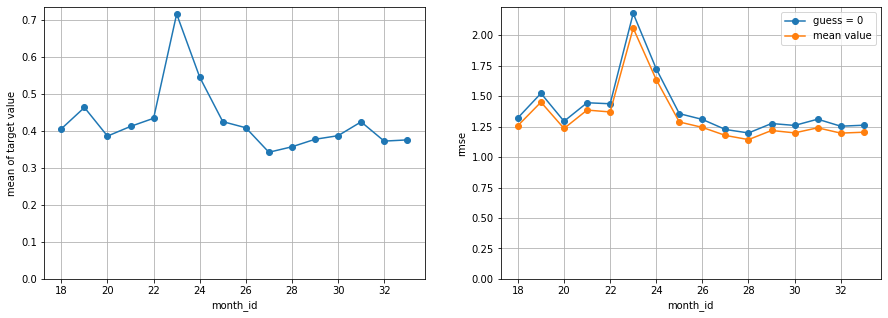

In [15]:
# analyse dataset
rmse_guess_train, rmse_base_train, rmse_guess_evalset, rmse_base_evalset = target_analysis_test(train_X,month_id_first=18)

In [16]:
features_to_keep_2=[]

#--------------
# CATEGORY
features_to_keep_2+=['item_category_id']                                      

features_to_keep_2+=['item_category_freq']                                    
features_to_keep_2+=['item_supercategory_freq']                               
features_to_keep_2+=['item_category_console_freq']                            
#features_to_keep_2+=['item_category_digital_freq']

#features_to_keep_2+=['item_category_freq_in_seniority']
#features_to_keep_2+=['item_supercategory_freq_in_seniority']
#features_to_keep_2+=['item_category_console_freq_in_seniority']
#features_to_keep_2+=['item_category_digital_freq_in_seniority']

features_to_keep_2+=['category_semiannual_avg_recent_rsd']
features_to_keep_2+=['category_semiannual_avg_annual_rsd']


#--------------
# SHOP
features_to_keep_2+=['shop_months_since_opening']

#--------------
# ITEM
#features_to_keep_2+=['item_freq_in_seniority']

#--------------
# RELATIVE TIME FEATURES
features_to_keep_2+=['item_months_since_release']
features_to_keep_2+=['item_months_since_first_sale_in_shop']
features_to_keep_2+=['item_months_since_last_sale_in_shop']










#--------------
# PRICES

features_to_keep_2+=['item_price_median_absolute_mean']                
features_to_keep_2+=['item_price_median_last_sale']                    
features_to_keep_2+=['item_price_min_absolute_min']                    
features_to_keep_2+=['item_price_max_absolute_max']                    

features_to_keep_2+=['item_price_median_compared_to_category_price_median_absolute_mean']                
features_to_keep_2+=['item_price_median_compared_to_category_price_median_last_sale']                    

features_to_keep_2+=['category_price_median_recent_mean']                    










#--------------
# SHOP-ITEM
#features_to_keep_2+=['item_quantity_absolute_mean']
features_to_keep_2+=['item_quantity_annual_mean']                    
features_to_keep_2+=['item_quantity_semiannual_mean']                
features_to_keep_2+=['item_quantity_recent_mean']                    
features_to_keep_2+=['item_quantity_lag_1']                          
features_to_keep_2+=['item_quantity_lag_12']                         

features_to_keep_2+=['item_quantity_extralin2']                       
features_to_keep_2+=['item_quantity_extralin3']    

features_to_keep_2+=['item_quantity_absolute_min']                    
features_to_keep_2+=['item_quantity_absolute_max']                    

#--------------
# ITEM
#features_to_keep_2+=['item_avg_sales_absolute_mean']
#features_to_keep_2+=['item_avg_sales_annual_mean']
#features_to_keep_2+=['item_avg_sales_semiannual_mean']
features_to_keep_2+=['item_avg_sales_recent_mean']                  
features_to_keep_2+=['item_avg_sales_lag_1']                        
#features_to_keep_2+=['item_avg_sales_lag_12']
features_to_keep_2+=['item_avg_sales_last_sale']                    


#features_to_keep_2+=['item_avg_sales_over_sold_absolute_mean']
#features_to_keep_2+=['item_avg_sales_over_sold_annual_mean']
#features_to_keep_2+=['item_avg_sales_over_sold_semiannual_mean']
features_to_keep_2+=['item_avg_sales_over_sold_recent_mean']                    
features_to_keep_2+=['item_avg_sales_over_sold_lag_1']                          
features_to_keep_2+=['item_avg_sales_over_sold_lag_12']                         
features_to_keep_2+=['item_avg_sales_over_sold_last_sale']                      


#features_to_keep_2+=['item_avg_sales_seniority_2_absolute_mean']
#features_to_keep_2+=['item_avg_sales_seniority_2_annual_mean']
#features_to_keep_2+=['item_avg_sales_seniority_2_semiannual_mean']
#features_to_keep_2+=['item_avg_sales_seniority_2_recent_mean']
#features_to_keep_2+=['item_avg_sales_seniority_2_lag_1']
#features_to_keep_2+=['item_avg_sales_seniority_2_lag_12']
#features_to_keep_2+=['item_avg_sales_seniority_2_last_sale']



#--------------
# SHOP
#features_to_keep_2+=['shop_avg_sales_seniority_2_absolute_mean']
#features_to_keep_2+=['shop_avg_sales_seniority_2_annual_mean']
#features_to_keep_2+=['shop_avg_sales_seniority_2_semiannual_mean']
#features_to_keep_2+=['shop_avg_sales_seniority_2_recent_mean']
#features_to_keep_2+=['shop_avg_sales_seniority_2_lag_1']
features_to_keep_2+=['shop_avg_sales_seniority_2_lag_12']                                             
                                                                    
#--------------
# SUPERCATEGORY
#features_to_keep_2+=['supercategory_avg_sales_seniority_2_absolute_mean']
#features_to_keep_2+=['supercategory_avg_sales_seniority_2_annual_mean']                
#features_to_keep_2+=['supercategory_avg_sales_seniority_2_semiannual_mean']
features_to_keep_2+=['supercategory_avg_sales_seniority_2_recent_mean']               
features_to_keep_2+=['supercategory_avg_sales_seniority_2_lag_1']                     
features_to_keep_2+=['supercategory_avg_sales_seniority_2_lag_12']                       

#--------------
# SHOP-SUPERCATEGORY
#features_to_keep_2+=['shop_supercategory_avg_sales_seniority_2_absolute_mean']
#features_to_keep_2+=['shop_supercategory_avg_sales_seniority_2_annual_mean']                            
#features_to_keep_2+=['shop_supercategory_avg_sales_seniority_2_semiannual_mean']
#features_to_keep_2+=['shop_supercategory_avg_sales_seniority_2_recent_mean']                              
#features_to_keep_2+=['shop_supercategory_avg_sales_seniority_2_lag_1']                                    
features_to_keep_2+=['shop_supercategory_avg_sales_seniority_2_lag_12']                                   

#--------------
# CATEGORY
#features_to_keep_2+=['category_avg_sales_seniority_2_absolute_mean']
features_to_keep_2+=['category_avg_sales_seniority_2_annual_mean']             
features_to_keep_2+=['category_avg_sales_seniority_2_semiannual_mean']             
features_to_keep_2+=['category_avg_sales_seniority_2_recent_mean']                   
features_to_keep_2+=['category_avg_sales_seniority_2_lag_1']                    
#features_to_keep_2+=['category_avg_sales_seniority_2_lag_12']                      

#--------------
# SHOP-CATEGORY
#features_to_keep_2+=['shop_category_avg_sales_seniority_2_absolute_mean']
features_to_keep_2+=['shop_category_avg_sales_seniority_2_annual_mean']                                              
features_to_keep_2+=['shop_category_avg_sales_seniority_2_semiannual_mean']                                            
features_to_keep_2+=['shop_category_avg_sales_seniority_2_recent_mean']                                                
features_to_keep_2+=['shop_category_avg_sales_seniority_2_lag_1']                                                      
features_to_keep_2+=['shop_category_avg_sales_seniority_2_lag_12']                                                     
                  


    
    

#--------------
# MONTHS SINCE RELEASE
#features_to_keep_2+=['category_months_since_release_avg_sales_seniority_2_absolute_mean']         
#features_to_keep_2+=['category_months_since_release_avg_sales_seniority_2_annual_mean']
#features_to_keep_2+=['category_months_since_release_avg_sales_seniority_2_semiannual_mean']
features_to_keep_2+=['category_months_since_release_avg_sales_seniority_2_recent_mean']              
#features_to_keep_2+=['category_months_since_release_avg_sales_seniority_2_lag_1']
#features_to_keep_2+=['category_months_since_release_avg_sales_seniority_2_lag_12']                  

features_to_keep_2+=['shop_category_months_since_release_avg_sales_seniority_2_absolute_mean']                       
#features_to_keep_2+=['shop_category_months_since_release_avg_sales_seniority_2_annual_mean'] 
#features_to_keep_2+=['shop_category_months_since_release_avg_sales_seniority_2_semiannual_mean']
#features_to_keep_2+=['shop_category_months_since_release_avg_sales_seniority_2_recent_mean']                         
#features_to_keep_2+=['shop_category_months_since_release_avg_sales_seniority_2_lag_1']               
features_to_keep_2+=['shop_category_months_since_release_avg_sales_seniority_2_lag_12']                               


#features_to_keep_2+=['supercategory_months_since_release_avg_sales_seniority_2_absolute_mean']
#features_to_keep_2+=['supercategory_months_since_release_avg_sales_seniority_2_annual_mean']
#features_to_keep_2+=['supercategory_months_since_release_avg_sales_seniority_2_semiannual_mean']
#features_to_keep_2+=['supercategory_months_since_release_avg_sales_seniority_2_recent_mean']
#features_to_keep_2+=['supercategory_months_since_release_avg_sales_seniority_2_lag_1']
features_to_keep_2+=['supercategory_months_since_release_avg_sales_seniority_2_lag_12']                             


#--------------
# MONTHS SINCE FIRST SALE IN SHOP
#features_to_keep_2+=['category_months_since_first_sale_in_shop_avg_sales_seniority_2_absolute_mean']                
#features_to_keep_2+=['category_months_since_first_sale_in_shop_avg_sales_seniority_2_annual_mean']           
#features_to_keep_2+=['category_months_since_first_sale_in_shop_avg_sales_seniority_2_semiannual_mean']
features_to_keep_2+=['category_months_since_first_sale_in_shop_avg_sales_seniority_2_recent_mean']              
#features_to_keep_2+=['category_months_since_first_sale_in_shop_avg_sales_seniority_2_lag_1']                  
#features_to_keep_2+=['category_months_since_first_sale_in_shop_avg_sales_seniority_2_lag_12']                  

#features_to_keep_2+=['shop_category_months_since_first_sale_in_shop_avg_sales_seniority_2_absolute_mean']            
#features_to_keep_2+=['shop_category_months_since_first_sale_in_shop_avg_sales_seniority_2_annual_mean']
#features_to_keep_2+=['shop_category_months_since_first_sale_in_shop_avg_sales_seniority_2_semiannual_mean']
#features_to_keep_2+=['shop_category_months_since_first_sale_in_shop_avg_sales_seniority_2_recent_mean']               
#features_to_keep_2+=['shop_category_months_since_first_sale_in_shop_avg_sales_seniority_2_lag_1']
features_to_keep_2+=['shop_category_months_since_first_sale_in_shop_avg_sales_seniority_2_lag_12']                



#--------------
# SPATIAL TRENDS
#features_to_keep_2+=['shop_category_avg_sales_compared_to_category_absolute_mean']
features_to_keep_2+=['shop_category_avg_sales_compared_to_category_annual_mean']              
#features_to_keep_2+=['shop_category_avg_sales_compared_to_category_semiannual_mean']
features_to_keep_2+=['shop_category_avg_sales_compared_to_category_recent_mean']            
#features_to_keep_2+=['shop_category_avg_sales_compared_to_category_lag_1']                  
#features_to_keep_2+=['shop_category_avg_sales_compared_to_category_lag_12']                


# TEMPORAL TRENDS
#features_to_keep_2+=['shop_avg_sales_compare_recent_mean_to_annual_mean']
#features_to_keep_2+=['shop_avg_sales_compare_lag1_to_annual_mean']                               
features_to_keep_2+=['shop_avg_sales_compare_lag12_to_annual_mean']                              

features_to_keep_2+=['supercategory_avg_sales_compare_recent_mean_to_annual_mean']         
#features_to_keep_2+=['supercategory_avg_sales_compare_lag1_to_annual_mean']
features_to_keep_2+=['supercategory_avg_sales_compare_lag12_to_annual_mean']               

features_to_keep_2+=['category_avg_sales_compare_recent_mean_to_annual_mean']            
#features_to_keep_2+=['category_avg_sales_compare_lag1_to_annual_mean']
features_to_keep_2+=['category_avg_sales_compare_lag12_to_annual_mean']                  

features_to_keep_2+=['category_avg_sales_compared_to_supercategory_recent_mean']           
#features_to_keep_2+=['category_avg_sales_compared_to_supercategory_lag_1']                
features_to_keep_2+=['category_avg_sales_compared_to_supercategory_lag_12']                      


# TEMPORAL TRENDS FOR SENIORITY 2 (months of the year where seniority 2 is boosted due to previous release of new items)
#features_to_keep_2+=['shop_avg_sales_seniority_2_compare_recent_mean_to_annual_mean']
#features_to_keep_2+=['shop_avg_sales_seniority_2_compare_lag1_to_annual_mean']                   
features_to_keep_2+=['shop_avg_sales_seniority_2_compare_lag12_to_annual_mean']                 

#features_to_keep_2+=['supercategory_avg_sales_seniority_2_compare_recent_mean_to_annual_mean']
#features_to_keep_2+=['supercategory_avg_sales_seniority_2_compare_lag1_to_annual_mean']
features_to_keep_2+=['supercategory_avg_sales_seniority_2_compare_lag12_to_annual_mean']         

#features_to_keep_2+=['category_avg_sales_seniority_2_compare_recent_mean_to_annual_mean']
#features_to_keep_2+=['category_avg_sales_seniority_2_compare_lag1_to_annual_mean']
features_to_keep_2+=['category_avg_sales_seniority_2_compare_lag12_to_annual_mean']              


# MONTH OF RELEASE
features_to_keep_2+=['supercategory_month_of_release_avg_sales_compared_to_supercategory_absolute_mean']          
features_to_keep_2+=['category_month_of_release_avg_sales_compared_to_category_absolute_mean']                    

In [17]:
# drop features
features_to_discard_2=list( set(list(train_X.columns)) - set(['month_id','item_quantity']+features_to_keep_2) )
train_X.drop(features_to_discard_2,axis=1,inplace=True)

# fill missing values
train_X['item_quantity_extralin2'].fillna(train_X['item_quantity_lag_1'],inplace=True)
train_X['item_quantity_extralin3'].fillna(train_X['item_quantity_lag_1'],inplace=True)
train_X.fillna(-1,inplace=True)

# split dataset
(X_train,Y_train,X_test) = datasplit_train_test(train_X,month_id_first)
eval_set = [(X_train,Y_train)]+datasplit_evalset(train_X,month_id_first)

# show dataset info
print('number of features to keep : '+str(len(features_to_keep_2)))
print('number of features kept    : '+str(len(X_train.columns)))

print(X_train.info(null_counts=True,verbose=True))


# clear memory space
del train_X
gc.collect()

(2353906, 67) (2353906,)
(111511, 67)
number of features to keep : 67
number of features kept    : 67
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2353906 entries, 6437735 to 10681411
Data columns (total 67 columns):
item_category_id                                                                    2353906 non-null float32
shop_months_since_opening                                                           2353906 non-null float32
item_category_freq                                                                  2353906 non-null float32
item_supercategory_freq                                                             2353906 non-null float32
item_category_console_freq                                                          2353906 non-null float32
category_semiannual_avg_recent_rsd                                                  2353906 non-null float32
category_semiannual_avg_annual_rsd                                                  2353906 non-null float32
item_months_sin

5657

### XGBRegressor - training for predictions

In [18]:
# SET XGBOOST PARAMETERS

xgb_params_2={'objective':        'reg:squarederror',
# TREE SPECIFIC PARAMETERS
              'max_depth':        6,
              'min_child_weight': 300,
              'subsample':        0.8,
              'colsample_bytree': 0.8,
# PARAMETERS RELATED TO THE LEARNING/BOOSTING PROCESS
              'learning_rate':    0.02,
              'n_estimators':     2000,  
# MISCELLANEOUS PARAMETERS
              'base_score':       0.4,
              'n_jobs':           4,
              'random_state':     2
             }



# FIT MODEL
ts=time.time()

xgbreg=XGBRegressor(**xgb_params_2)
xgbreg.fit(X_train,Y_train,eval_set=eval_set,eval_metric='rmse',verbose=False)

print(time.time()-ts)

/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


14655.949684858322


#### TRAINING SET ###
RMSE (last, min, base, guess): 0.797133 , 0.797133 , 1.3676968236541185 , 1.4344214

#### EVAL SET ###
RMSE (last): [0.7609, 0.8329, 0.7171, 0.7694, 0.773, 1.0908, 0.9145, 0.7878, 0.7505, 0.7284, 0.7026, 0.7257, 0.7594, 0.7796, 0.7559, 0.748]
RMSE (min): [0.7609, 0.8329, 0.7171, 0.7694, 0.773, 1.0908, 0.9145, 0.7878, 0.7505, 0.7284, 0.7026, 0.7257, 0.7594, 0.7796, 0.7559, 0.748]
RMSE (base): [1.2583, 1.451, 1.235, 1.3859, 1.3705, 2.0583, 1.6354, 1.2881, 1.2436, 1.1777, 1.1435, 1.2183, 1.1987, 1.2402, 1.1968, 1.2042]
RMSE (guess): [1.3223, 1.5234, 1.294, 1.446, 1.4377, 2.1795, 1.7241, 1.3566, 1.3091, 1.2265, 1.198, 1.2755, 1.2598, 1.311, 1.2535, 1.2616]


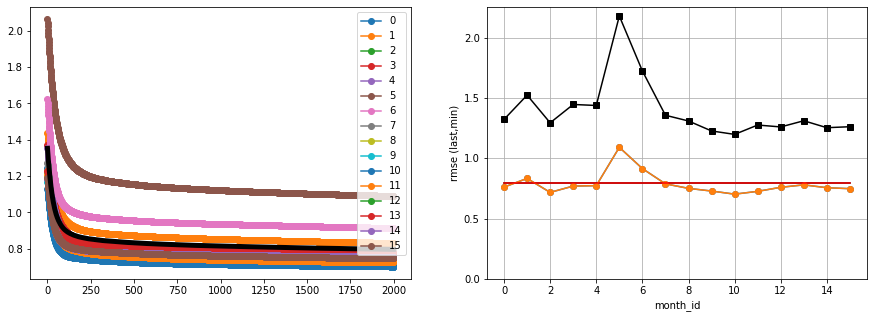

In [19]:
# PERFORMANCE ANALYSIS
performance_analysis_test(xgbreg,rmse_guess_train,rmse_base_train,rmse_guess_evalset,rmse_base_evalset)

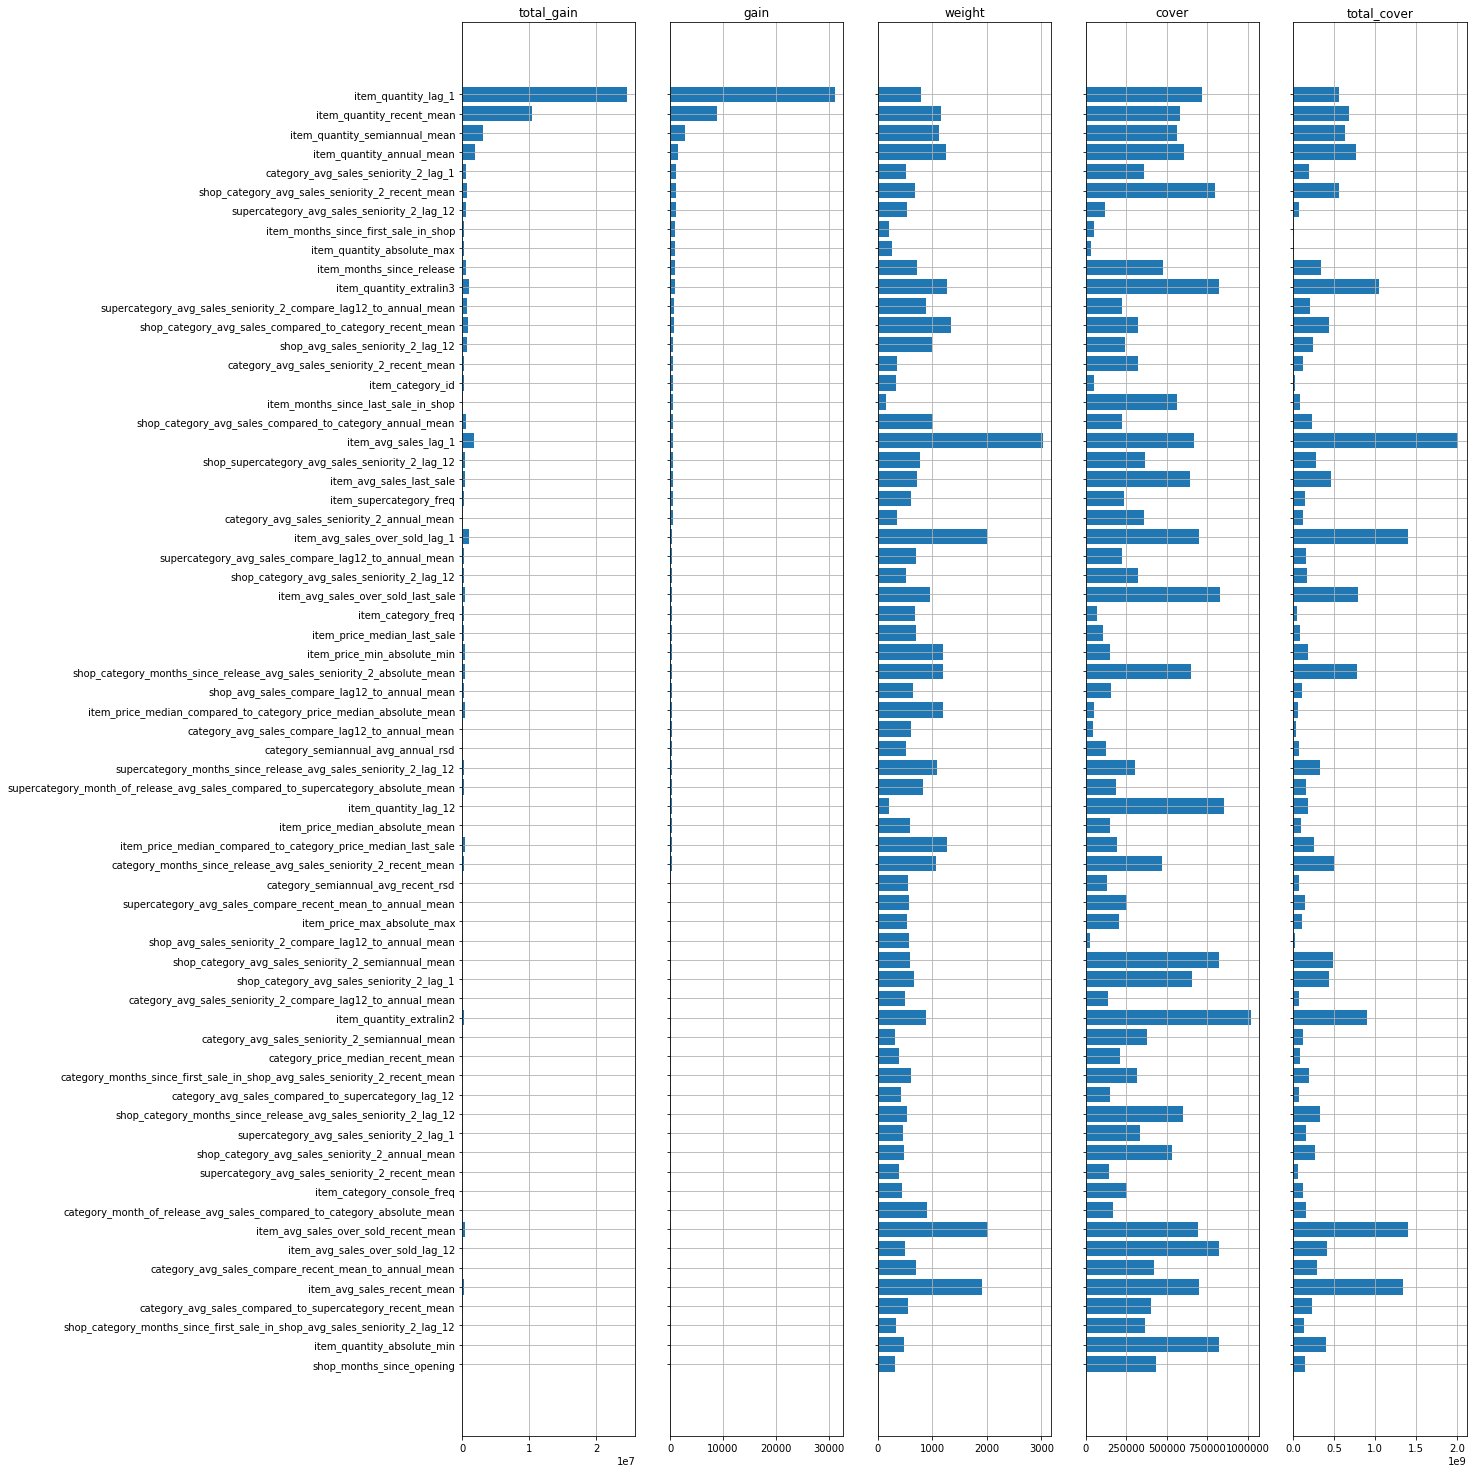

In [20]:
# FEATURE IMPORTANCE
plot_feature_importance(xgbreg,X_train)

### Save model and test set

In [21]:
# create directory
create_directory(os.path.join(DATA_FOLDER, 'predictions/models/xgbreg_seniority2'))

# export model
pickle.dump(xgbreg, open(os.path.join(DATA_FOLDER,'predictions/models/xgbreg_seniority2/model.pickle'), 'wb'))
X_test.to_pickle(os.path.join(DATA_FOLDER,'predictions/models/xgbreg_seniority2/X_test.pkl'))

directory ../data/predictions/models/xgbreg_seniority2 created succesfully !


In [22]:
# clear memory
del X_train, Y_train, X_test
del eval_set
del rmse_guess_train, rmse_base_train, rmse_guess_evalset, rmse_base_evalset
del xgbreg

gc.collect()

61078

In [23]:
reset_variable_space